<a href="https://colab.research.google.com/github/Harm1995/CTA-sensitivity/blob/master/Analysing_the_counts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages


In [0]:
try:
  import iminuit
  from iminuit import Minuit

except:
  !pip install iminuit

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random
import scipy
from scipy.stats import norm
import astropy
from astropy.io import fits
import seaborn as sns
import time

sns.set()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Downloading the data

In [3]:
alt_shape = (15, 47, 20, 20)
orig_shape = (9, 47, 20, 20)
signal_shape = (47, 20, 20)

files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
original_file = files_paths + 'Original_model_data.txt.txt'
alternative_file = files_paths + 'alternative_model.txt'
signal_file = files_paths + 'signal_data.txt'

simulated_backgrounds = np.loadtxt(original_file).reshape(orig_shape)
model_backgrounds = np.loadtxt(alternative_file).reshape(alt_shape)
signal_c = np.loadtxt(signal_file).reshape(signal_shape)

print (simulated_backgrounds.shape)
print (model_backgrounds.shape)


TeV = 10**-6
ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"
energy_list1 = np.array(fits.getdata(ring_path + 'ics_ring_1.fits', ext=1))
energies = []
for energy in energy_list1:
    E = float(str(energy)[1:-2])
    energies.append(E)
energies = np.array(energies)
energies = energies * TeV   




(9, 47, 20, 20)
(15, 47, 20, 20)


# Generating the simulated counts map

In [0]:
def random_counts_with_signal(signal_strength,sigma, all_backgrounds, signal_conv):
  count_matrix = np.zeros(signal_conv.shape)
  for mapn in all_backgrounds:
    after_norm = np.random.normal(1, sigma) * mapn
    after_norm = after_norm.clip(0)
    with_pois = np.random.poisson(after_norm)
    count_matrix += with_pois
  signal_norm = signal_conv * signal_strength
  signal_pois = np.random.poisson(signal_norm)
  count_matrix += signal_pois


  return count_matrix

# Making the classes

In [0]:

class analysis:

  def __init__(self, signal_strength, model_backgrounds, signal_conv,sigma,simulated_backgrounds, long):
    self.signal_strength = signal_strength
    self.simulated_backgrounds = simulated_backgrounds
    self.counts_m = random_counts_with_signal(signal_strength,sigma, simulated_backgrounds, signal_conv)
    self.all_backgrounds = model_backgrounds
    self.signal_conv = signal_conv
    self.sigma = sigma
    self.long = long

#  def random_counts_with_signal(self):
#    count_matrix = np.zeros(self.signal_conv.shape)
#    for k,i,j in np.ndindex(self.signal_conv.shape):
#      for mapn in self.all_backgrounds:
#        expected = mapn[k][i][j]
#        if expected > 0:
#          count_matrix[k][i][j] +=  np.random.normal(expected, self.sigma*expected)
#      expected = self.signal_conv[k][i][j] * self.signal_strength
#      count_matrix[k][i][j] +=  np.random.normal(expected, self.sigma*expected)
#
#    return count_matrix  

  
  def L0_model_long(self, params, i,j,k):
    """
    The model for CTA without a signal component
    """

    tot_back = 0
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a][k][i][j]
    return tot_back

  def L1_model_long(self, params, i,j,k):
    """
    The model for CTA with a signal component
    """

    tot_back = 0
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a][k][i][j]  
    
    tot_back += params[-1] * self.signal_conv[k][i][j]
    
    return tot_back

  def L0_model_short(self, params, i,j,k):
    """
    The model for CTA without a signal component
    """
    tot_back = 0

    for a in range(len(self.all_backgrounds)):
      if a < 4:
        tot_back += params[0] * self.all_backgrounds[a][k][i][j]
      elif a < 8:
        tot_back += params[1] * self.all_backgrounds[a][k][i][j]
      else:
        tot_back += params[2] * self.all_backgrounds[a][k][i][j]

    return tot_back


  def L1_model_short(self, params, i,j,k):
      """
      The model for CTA with a signal component
      """
      tot_back = 0

      for a in range(len(self.all_backgrounds)):
        if a < 4:
          tot_back += params[0] * self.all_backgrounds[a][k][i][j]
        elif a < 8:
          tot_back += params[1] * self.all_backgrounds[a][k][i][j]
        else:
          tot_back += params[2] * self.all_backgrounds[a][k][i][j]

      tot_back += params[3] * self.signal_conv[k][i][j]
      return tot_back


  def lik0(self,params):
    """
    Function that computes the likelihood for a given set of parameters without a signal
    """
    if long:
      p_sum = 0
      for k,i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[k][i][j]
        counts_model = self.L0_model_long(params, i,j,k)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum
    else:
      p_sum = 0
      for k,i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[k][i][j]
        counts_model = self.L0_model_short(params, i,j,k)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum



  def lik1(self,params):
    """
    Function that computes the likelihood for a given set of parameters of the model with a signal 
    """
    if long:
      p_sum = 0
      for k,i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[k][i][j]
        counts_model = self.L1_model_long(params, i,j,k)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum
    else:
      p_sum = 0
      for k,i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[k][i][j]
        counts_model = self.L1_model_short(params, i,j,k)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum




  def Test_stat(self):
    if long:
      init_gues0 = []
      init_gues1 = []
      range0 = (0, 10)
      range1 = (0, 10)
      limit_list1 = []
      limit_list2 = []
      for __ in range(len(self.all_backgrounds)):
        init_gues0.append(1)
        init_gues1.append(1)
        limit_list1.append(range0)
        limit_list2.append(range1)
      limit_list2.append((0, None))
      init_gues1.append(self.signal_strength)
      m_0 = Minuit.from_array_func(self.lik0, init_gues0, error = 0.1, limit= limit_list1, errordef=0.5)
      m_1 = Minuit.from_array_func(self.lik1, init_gues1, error = 0.1, limit= limit_list2, errordef=0.5)
      c = m_0.migrad() 
      d = m_1.migrad()
      a = -m_0.fval 
      b = -m_1.fval
      T = -2*(a-b)
      return T, c,d,m_0,m_1
    else:
      init_gues0 = [1,1,1]
      init_gues1 = [1,1,1,self.signal_strength]
      range0 = (0.5, 2.5)
      range1 = (0.7, 1.3)
      m_0 = Minuit.from_array_func(self.lik0, init_gues0, error = 0.25, limit= [range0,range0,range0], errordef=0.5,)
      m_1 = Minuit.from_array_func(self.lik1, init_gues1, error = 0.25, limit= [range1,range1,range1,(0, None)], errordef=0.5)
      m_0.minos()
      m_1.minos()
      a = -m_0.fval 
      b = -m_1.fval
      T = -2*(a-b)
      return T, m_1.get_param_states()





## Renormalising the alternative GDE again:

In [0]:
GCE_model_tot = np.sum(model_backgrounds[4:-1])
GCE_simulated_tot = np.sum(simulated_backgrounds[4:-1])
ratio = GCE_model_tot/GCE_simulated_tot

for i in range(4,15):
  model_backgrounds[i] = model_backgrounds[i] / ratio 

print (np.sum(np.sum(model_backgrounds[:-1])))
print (np.sum(simulated_backgrounds[:-1]))



45749378903.351906
45749378903.351906


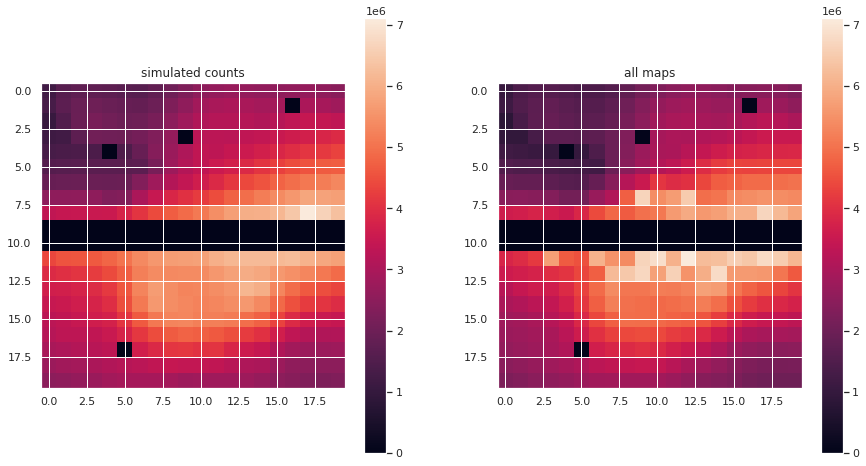

60202937259.79703
66376583650.0


In [6]:
signal_strength = 0
sigma = 0
long = True
M1 = analysis(signal_strength, model_backgrounds, signal_c, sigma, simulated_backgrounds, long)
M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)

a = M1.counts_m
b = M2.counts_m

tot = np.zeros(shape = model_backgrounds[1].shape)
for maps in model_backgrounds:
  tot += maps



index = 20
fig, ax = plt.subplots(1,2, figsize = (15,8))
m1 = ax[0].imshow(a[index])
m2 = ax[1].imshow(tot[index])
ax[0].set_title('simulated counts')
ax[1].set_title('all maps')
plt.colorbar(m1, ax = ax[0])
plt.colorbar(m2, ax = ax[1])
m1.set_clim(0, np.max(a[index]))
m2.set_clim(0, np.max(a[index]))
plt.show()

print (np.sum(tot))
print (np.sum(a))


In [0]:
signal_strength = 0.05
sigma = 0
long = True
M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
T, c,d = M2.Test_stat()

# Some analysis

## original model

### Sigma = 0, ss = 0.05


In [0]:
signal_strength = 0.05
sigma = 0
long = True
M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
T, c,d, m_0, m_1 = M2.Test_stat()



In [0]:
c

------------------------------------------------------------------
| FCN = -8.221E+11              |     Ncalls=352 (363 total)     |
| EDM = 6.17E+04 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.130   |   0.000   |            |            |    0    |   10    |       |
| 1 | x1   |   0.993   |   0.000   |            |            |    0    |   10    |       |
| 2 | x2   |   0.732   |   0.000   |            |            |    0    |   10    |       |
| 3 | x3   |   2.614   |   0.001   |            |            |    0    |   10    |       |
| 4 | x4   |   1.078   |   0.000   |            |            |    0    |   10    |       |
| 5 | x5   |   0.988   |   0.000   |            |            |    0    |   10    |       |
| 6 | x6   |   0.389   |   0.003   |            |            |    0    |   10    |       |
| 7 | x7   |   1.529   |   0.003   |            |            |    0    |   10    |       |
| 8 | x8   |   1.009   |   0.000   |            |            |    0    |   10    |       |
------------------------------------------------------------------------------------------

In [0]:
d


------------------------------------------------------------------
| FCN = -8.221E+11              |     Ncalls=160 (160 total)     |
| EDM = 3.99 (Goal: 0.0001)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.000   |   0.000   |            |            |    0    |   10    |       |
| 1 | x1   |   1.000   |   0.000   |            |            |    0    |   10    |       |
| 2 | x2   |   1.000   |   0.001   |            |            |    0    |   10    |       |
| 3 | x3   |   1.000   |   0.002   |            |            |    0    |   10    |       |
| 4 | x4   |   1.000   |   0.000   |            |            |    0    |   10    |       |
| 5 | x5   |   1.000   |   0.000   |            |            |    0    |   10    |       |
| 6 | x6   |   1.000   |   0.008   |            |            |    0    |   10    |       |
| 7 | x7   |   1.000   |   0.007   |            |            |    0    |   10    |       |
| 8 | x8   |   1.000   |   0.000   |            |            |    0    |   10    |       |
| 9 | x9   | 0.500E-1  | 0.000E-1  |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [0]:
print (T)

13596731.570800781


### sigma = 0.3 ss = 0.1

In [0]:
signal_strength = 0.1
sigma = 0.3
long = True
M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
T, c,d, m_0, m_1 = M2.Test_stat()


In [8]:
c

------------------------------------------------------------------
| FCN = -9.029E+11              |     Ncalls=528 (539 total)     |
| EDM = 3.93E+04 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |    1.3    |    2.2    |            |            |    0    |   10    |       |
| 1 | x1   |    1.2    |    2.1    |            |            |    0    |   10    |       |
| 2 | x2   |    1.9    |    2.5    |            |            |    0    |   10    |       |
| 3 | x3   |    3.8    |    3.2    |            |            |    0    |   10    |       |
| 4 | x4   |    0.6    |    1.5    |            |            |    0    |   10    |       |
| 5 | x5   |    0.7    |    1.6    |            |            |    0    |   10    |       |
| 6 | x6   |   0.18    |   1.15    |            |            |    0    |   10    |       |
| 7 | x7   |   0.001   |   1.199   |            |            |    0    |   10    |       |
| 8 | x8   |    0.8    |    1.7    |            |            |    0    |   10    |       |
------------------------------------------------------------------------------------------

In [9]:
d

------------------------------------------------------------------
| FCN = -9.029E+11              |     Ncalls=644 (655 total)     |
| EDM = 2.06E+04 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.847   |   0.000   |            |            |    0    |   10    |       |
| 1 | x1   |   1.258   |   0.000   |            |            |    0    |   10    |       |
| 2 | x2   |   1.772   |   0.001   |            |            |    0    |   10    |       |
| 3 | x3   |   1.087   |   0.003   |            |            |    0    |   10    |       |
| 4 | x4   |   0.495   |   0.000   |            |            |    0    |   10    |       |
| 5 | x5   |   0.748   |   0.000   |            |            |    0    |   10    |       |
| 6 | x6   |  1.22E-2  |  0.03E-2  |            |            |    0    |   10    |       |
| 7 | x7   | 1.073E-2  | 0.029E-2  |            |            |    0    |   10    |       |
| 8 | x8   |   0.745   |   0.000   |            |            |    0    |   10    |       |
| 9 | x9   | 0.997E-1  | 0.000E-1  |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [0]:
print (T)

46184760.846191406


### ss = 1 sigma = 0.3

In [0]:
signal_strength = 1
sigma = 0.3
long = True
M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
T, c,d, m_0, m_1 = M2.Test_stat()

In [0]:
c

------------------------------------------------------------------
| FCN = -1.424E+12              |     Ncalls=981 (992 total)     |
| EDM = 4.68E+05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |  0.745E1  |  0.000E1  |            |            |    0    |   10    |       |
| 1 | x1   |  2.97E-5  |  0.09E-5  |            |            |    0    |   10    |       |
| 2 | x2   |  0.806E1  |  0.000E1  |            |            |    0    |   10    |       |
| 3 | x3   |  1.000E1  |  0.000E1  |            |            |    0    |   10    |       |
| 4 | x4   |   3.141   |   0.000   |            |            |    0    |   10    |       |
| 5 | x5   |  2.47E-5  |  0.04E-5  |            |            |    0    |   10    |       |
| 6 | x6   |  0.996E1  |  0.000E1  |            |            |    0    |   10    |       |
| 7 | x7   |   0.506   |   0.005   |            |            |    0    |   10    |       |
| 8 | x8   |   1.599   |   0.000   |            |            |    0    |   10    |       |
------------------------------------------------------------------------------------------

In [0]:
d

------------------------------------------------------------------
| FCN = -1.426E+12              |    Ncalls=1210 (1210 total)    |
| EDM = 1.64E+04 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.219   |   0.000   |            |            |    0    |   10    |       |
| 1 | x1   |   0.401   |   0.000   |            |            |    0    |   10    |       |
| 2 | x2   |  0.999E1  |  0.000E1  |            |            |    0    |   10    |       |
| 3 | x3   |  0.72E-4  |  0.23E-4  |            |            |    0    |   10    |       |
| 4 | x4   |   1.508   |   0.000   |            |            |    0    |   10    |       |
| 5 | x5   |   0.768   |   0.000   |            |            |    0    |   10    |       |
| 6 | x6   |  2.1E-3   |  1.6E-3   |            |            |    0    |   10    |       |
| 7 | x7   |   1.576   |   0.003   |            |            |    0    |   10    |       |
| 8 | x8   |   1.310   |   0.000   |            |            |    0    |   10    |       |
| 9 | x9   |   1.348   |   0.000   |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [0]:
print (T)

5187385953.955566


### ss = 0.1 sigma = 0.1

In [0]:
signal_strength = 0.1
sigma = 0.1
long = True
M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
T, c,d, m_0, m_1 = M2.Test_stat()

In [0]:
c


------------------------------------------------------------------
| FCN = -9.554E+11              |     Ncalls=670 (670 total)     |
| EDM = 3.77E+04 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.352   |   0.000   |            |            |    0    |   10    |       |
| 1 | x1   |   0.926   |   0.000   |            |            |    0    |   10    |       |
| 2 | x2   |   0.548   |   0.000   |            |            |    0    |   10    |       |
| 3 | x3   |  0.356E1  |  0.000E1  |            |            |    0    |   10    |       |
| 4 | x4   |   0.948   |   0.000   |            |            |    0    |   10    |       |
| 5 | x5   |   0.762   |   0.000   |            |            |    0    |   10    |       |
| 6 | x6   |  0.28E-4  |  1.91E-4  |            |            |    0    |   10    |       |
| 7 | x7   |   1.669   |   0.003   |            |            |    0    |   10    |       |
| 8 | x8   |   1.015   |   0.000   |            |            |    0    |   10    |       |
------------------------------------------------------------------------------------------

In [0]:
d

------------------------------------------------------------------
| FCN = -9.555E+11              |     Ncalls=397 (397 total)     |
| EDM = 1.85E+04 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.883   |   0.000   |            |            |    0    |   10    |       |
| 1 | x1   |   0.984   |   0.000   |            |            |    0    |   10    |       |
| 2 | x2   |   0.843   |   0.000   |            |            |    0    |   10    |       |
| 3 | x3   |   1.269   |   0.000   |            |            |    0    |   10    |       |
| 4 | x4   |   0.893   |   0.000   |            |            |    0    |   10    |       |
| 5 | x5   |   0.837   |   0.000   |            |            |    0    |   10    |       |
| 6 | x6   |   0.138   |   0.005   |            |            |    0    |   10    |       |
| 7 | x7   |   0.200   |   0.004   |            |            |    0    |   10    |       |
| 8 | x8   |   0.993   |   0.000   |            |            |    0    |   10    |       |
| 9 | x9   | 0.998E-1  | 0.000E-1  |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [0]:
T

46324516.349853516

## Alternative GDE

### sigma = 0.3, ss = 1, Alternative GDE model

In [0]:
sigma = 0.3
signal_strength = 1
long = True
M1 = analysis(signal_strength, model_backgrounds, signal_c, sigma, simulated_backgrounds, long)

T, c,d, m_0, m_1 = M1.Test_stat()

In [0]:
c

------------------------------------------------------------------
| FCN = -1.357E+12              |    Ncalls=2084 (2094 total)    |
| EDM = 367 (Goal: 0.0001)      |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |  0.483E1  |  0.000E1  |            |            |    0    |   10    |       |
| 1 | x1   |  0.32E-7  |  0.29E-7  |            |            |    0    |   10    |       |
| 2 | x2   |  1.000E1  |  0.000E1  |            |            |    0    |   10    |       |
| 3 | x3   |  1.000E1  |  0.000E1  |            |            |    0    |   10    |       |
| 4 | x4   |  2.2E-8   |  2.9E-8   |            |            |    0    |   10    |       |
| 5 | x5   |  2.3E-6   |  1.4E-6   |            |            |    0    |   10    |       |
| 6 | x6   | 0.005E-5  | 0.438E-5  |            |            |    0    |   10    |       |
| 7 | x7   |  0.49E-5  |  0.21E-5  |            |            |    0    |   10    |       |
| 8 | x8   |  0.6E-7   |  0.4E-7   |            |            |    0    |   10    |       |
| 9 | x9   |   1.070   |   0.000   |            |            |    0    |   10    |       |
| 10| x10  | 1.536E-6  | 0.025E-6  |            |            |    0    |   10    |       |
| 11| x11  |   0.938   |   0.000   |            |            |    0    |   10    |       |
| 12| x12  |  1.3E-8   |  1.6E-8   |            |            |    0    |   10    |       |
| 13| x13  |   0.556   |   0.000   |            |            |    0    |   10    |       |
| 14| x14  |   1.092   |   0.000   |            |            |    0    |   10    |       |
------------------------------------------------------------------------------------------

In [0]:
d

------------------------------------------------------------------
| FCN = -1.359E+12              |    Ncalls=2172 (2172 total)    |
| EDM = 4.53E+03 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.652   |   0.000   |            |            |    0    |   10    |       |
| 1 | x1   |   0.771   |   0.000   |            |            |    0    |   10    |       |
| 2 | x2   |  1.61E-3  |  0.16E-3  |            |            |    0    |   10    |       |
| 3 | x3   |  0.8E-5   |  0.3E-5   |            |            |    0    |   10    |       |
| 4 | x4   |   0.425   |   0.000   |            |            |    0    |   10    |       |
| 5 | x5   |  0.999E1  |  0.000E1  |            |            |    0    |   10    |       |
| 6 | x6   |  1.000E1  |  0.000E1  |            |            |    0    |   10    |       |
| 7 | x7   |  0.999E1  |  0.000E1  |            |            |    0    |   10    |       |
| 8 | x8   |  0.87E-5  |  0.10E-5  |            |            |    0    |   10    |       |
| 9 | x9   |  0.8E-7   |  1.0E-7   |            |            |    0    |   10    |       |
| 10| x10  | 1.302E-1  | 0.001E-1  |            |            |    0    |   10    |       |
| 11| x11  |  0.67E-4  |  0.08E-4  |            |            |    0    |   10    |       |
| 12| x12  |  0.92E-4  |  0.05E-4  |            |            |    0    |   10    |       |
| 13| x13  |  0.92E-5  |  0.06E-5  |            |            |    0    |   10    |       |
| 14| x14  |   0.947   |   0.000   |            |            |    0    |   10    |       |
| 15| x15  |   0.974   |   0.000   |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [0]:
T

3317288784.1918945

### Sigma = 0.5, ss = 1 alternative GDE

In [0]:
sigma = 0.3
signal_strength = 0.1
long = True
M1 = analysis(signal_strength, model_backgrounds, signal_c, sigma, simulated_backgrounds, long)

T, c,d, m_0, m_1 = M1.Test_stat()

In [0]:
c

------------------------------------------------------------------
| FCN = -1.321E+12              |    Ncalls=1755 (1766 total)    |
| EDM = 1.93E+04 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |  0.475E1  |  0.000E1  |            |            |    0    |   10    |       |
| 1 | x1   |   1.156   |   0.000   |            |            |    0    |   10    |       |
| 2 | x2   | 0.506E-1  | 0.001E-1  |            |            |    0    |   10    |       |
| 3 | x3   |  1.68E-5  |  0.07E-5  |            |            |    0    |   10    |       |
| 4 | x4   |   0.946   |   0.000   |            |            |    0    |   10    |       |
| 5 | x5   |  1.000E1  |  0.000E1  |            |            |    0    |   10    |       |
| 6 | x6   |  1.000E1  |  0.000E1  |            |            |    0    |   10    |       |
| 7 | x7   |  1.000E1  |  0.000E1  |            |            |    0    |   10    |       |
| 8 | x8   | 0.770E-3  | 0.004E-3  |            |            |    0    |   10    |       |
| 9 | x9   | 0.318E-3  | 0.002E-3  |            |            |    0    |   10    |       |
| 10| x10  |   0.499   |   0.000   |            |            |    0    |   10    |       |
| 11| x11  |   0.337   |   0.000   |            |            |    0    |   10    |       |
| 12| x12  |   1.195   |   0.000   |            |            |    0    |   10    |       |
| 13| x13  |   0.374   |   0.000   |            |            |    0    |   10    |       |
| 14| x14  | 0.367E-2  | 0.002E-2  |            |            |    0    |   10    |       |
------------------------------------------------------------------------------------------

In [0]:
d

------------------------------------------------------------------
| FCN = -1.321E+12              |    Ncalls=2275 (2286 total)    |
| EDM = 8.51E+11 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |    4.7    |    2.2    |            |            |    0    |   10    |       |
| 1 | x1   |    0.4    |    1.1    |            |            |    0    |   10    |       |
| 2 | x2   |   10.0    |    1.1    |            |            |    0    |   10    |       |
| 3 | x3   |   0.001   |   1.199   |            |            |    0    |   10    |       |
| 4 | x4   |    1.1    |    1.4    |            |            |    0    |   10    |       |
| 5 | x5   |   10.0    |    1.2    |            |            |    0    |   10    |       |
| 6 | x6   |   10.0    |    1.2    |            |            |    0    |   10    |       |
| 7 | x7   |   10.0    |    1.2    |            |            |    0    |   10    |       |
| 8 | x8   |   0.002   |   0.750   |            |            |    0    |   10    |       |
| 9 | x9   |   0.000   |   1.199   |            |            |    0    |   10    |       |
| 10| x10  |    0.5    |    1.4    |            |            |    0    |   10    |       |
| 11| x11  |   0.15    |   1.13    |            |            |    0    |   10    |       |
| 12| x12  |    1.2    |    0.5    |            |            |    0    |   10    |       |
| 13| x13  |    0.6    |    1.5    |            |            |    0    |   10    |       |
| 14| x14  |   0.000   |   1.198   |            |            |    0    |   10    |       |
| 15| x15  |   0.04    |   0.20    |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [0]:
print (T)

-147758.55859375


# long runs


## 50 runs with sigma = 0.3 and signal = 0.5

In [0]:
sigma = 0.3
long = True
times = 50
signal_strength = 0.5
recovered_strength = []
T_values = []

per_s_ss = []
per_s_T = []
for i in range(times):
  M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
  T, c,d, m_0, m_1 = M2.Test_stat()
  per_s_T.append(T)
  per_s_ss.append(m_1.values[9])
  print (f"ss {signal_strength} at trial {i}: T = {T} and rss = {m_1.values[9]}")


In [0]:
per_s_T = np.array(per_s_T)
mean = np.mean(per_s_T)
std = per_s_T.std()
perc = std / mean  * 100

per_s_ss = np.array(per_s_ss)

mean_ss = per_s_ss.mean()
std_ss = per_s_ss.std()
perc_ss = std_ss / mean_ss * 100

print (f"for s = 0.5 we get a average Ts of {'{:.2e}'.format(mean)} +/- {round(perc,1)} %")
print (f"for s = 0.5 we extract a signal of {'{:.2e}'.format(mean_ss)} +/- {round(perc_ss,1)} % ")

for s = 0.5 we get a average Ts of 1.19e+09 +/- 11.6 %
for s = 0.5 we extract a signal of 5.00e-01 +/- 0.3 % 


## 10 runs sigma = 0.25 

In [0]:
sigma = 0.3
long = True
times = 10
recovered_strength = []
T_values = []
signal_strengths = np.linspace(0.001,0.1,  10)

for signal_strength in signal_strengths:
  per_s_ss = []
  per_s_T = []
  for i in range(times):
    M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
    T, c,d, m_0, m_1 = M2.Test_stat()
    per_s_T.append(T)
    per_s_ss.append(m_1.values[9])
    print (f"ss {signal_strength} at trial {i}: T = {T} and rss = {m_1.values[9]}")
  
  per_s_T = np.array(per_s_T)
  mean = np.mean(per_s_T)
  std = per_s_T.std()
  perc = std / mean  * 100

  per_s_ss = np.array(per_s_ss)

  mean_ss = per_s_ss.mean()
  std_ss = per_s_ss.std()
  perc_ss = std_ss / mean_ss * 100
  print ("------------")
  print (f"for s = 0.5 we get a average Ts of {'{:.2e}'.format(mean)} +/- {round(perc,1)} %")
  print (f"for s = 0.5 we extract a signal of {'{:.2e}'.format(mean_ss)} +/- {round(perc_ss,1)} % ")
  print ("------------")
  T_values.append(per_s_T)
  recovered_strength.append(per_s_ss)



ss 0.001 at trial 0: T = -606783.0344238281 and rss = 0.000335154138903615
ss 0.001 at trial 1: T = -240796.47290039062 and rss = 1.487681575440547e-05
ss 0.001 at trial 2: T = -34511.422119140625 and rss = 0.00013300415443096014
ss 0.001 at trial 3: T = -2892586.9104003906 and rss = 0.00030743319648807166
ss 0.001 at trial 4: T = 18353.226318359375 and rss = 0.0010788965941022077
ss 0.001 at trial 5: T = 3620230.8247070312 and rss = 0.00020572888291137126
ss 0.001 at trial 6: T = 27374.5439453125 and rss = 0.00032133883706997324
ss 0.001 at trial 7: T = -25760.0517578125 and rss = 1.0835911127493603e-05
ss 0.001 at trial 8: T = -223380.7802734375 and rss = 9.706888917260237e-05
ss 0.001 at trial 9: T = -58791.69482421875 and rss = 0.0009809279442150043
------------
for s = 0.5 we get a average Ts of -4.17e+04 +/- -3554.9 %
for s = 0.5 we extract a signal of 3.49e-04 +/- 103.1 % 
------------
ss 0.012 at trial 0: T = 972725.9956054688 and rss = 0.010991903490568333
ss 0.012 at trial 1:

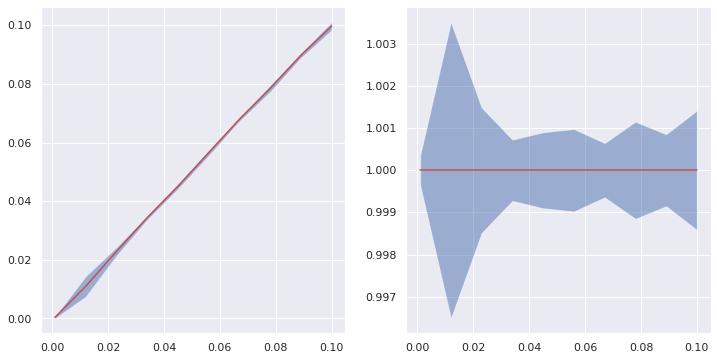

In [0]:
per_s_ss = np.array(per_s_ss)
per_s_T = np.array(per_s_T)

recovered_strength = np.array(recovered_strength)
mean_ss_list = []
sigma_upper_list = []
sigma_lower_list = []

relative_ss_list = []
relative_sigma_upper_list = []
relative_sigma_lower_list = []

for i,signal_strength in enumerate(signal_strengths[:len(recovered_strength)]):
  mean_ss = np.mean(recovered_strength[i])
  std = recovered_strength[i].std()
  mean_ss_list.append(mean_ss)
  sigma_upper_list.append(mean_ss + std)
  sigma_lower_list.append(mean_ss - std)

  relative = (mean - std) / mean
  relative_ss_list.append(relative)
  relative_sigma_upper_list.append(relative + std)
  relative_sigma_lower_list.append(relative - std)

plt.figure(figsize = (12,6))
plt.grid(True)
plt.subplot(1, 2, 1)
plt.fill_between(signal_strengths[:len(recovered_strength)],sigma_lower_list , sigma_upper_list,alpha = 0.5)
plt.plot(signal_strengths[:len(recovered_strength)], mean_ss_list , c= 'r')
plt.subplot(1, 2, 2)
plt.fill_between(signal_strengths[:len(recovered_strength)],relative_sigma_lower_list , relative_sigma_upper_list, alpha = 0.5)
plt.plot(signal_strengths[:len(recovered_strength)], relative_ss_list, c= 'r')
plt.show()


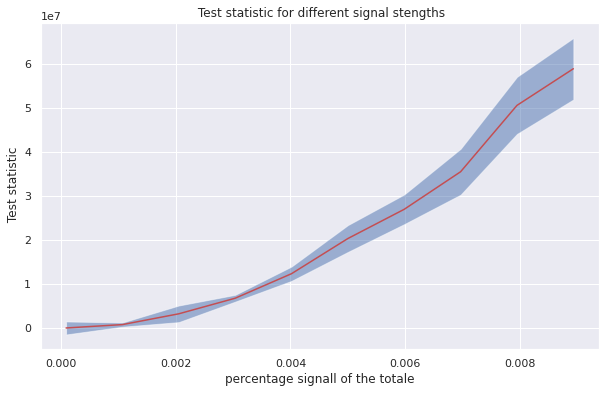

In [0]:
signal_perc = np.sum(signal_c) / np.sum(simulated_backgrounds + signal_c) *100
mean_T_list = []
sigma_upper_list_T = []
sigma_lower_list_T = []

T_values = np.array(T_values)

for i,signal_strength in enumerate(signal_strengths[:len(T_values)]):
  mean_T = np.mean(T_values[i])
  std = T_values[i].std()
  mean_T_list.append(mean_T)
  sigma_upper_list_T.append(mean_T + std)
  sigma_lower_list_T.append(mean_T - std)

plt.figure(figsize = (10,6))
plt.plot(signal_perc*signal_strengths[:len(T_values)],mean_T_list, 'r')
plt.fill_between(signal_perc *signal_strengths[:len(T_values)],sigma_upper_list_T , sigma_lower_list_T, alpha = 0.5)
plt.xlabel('signal fraction (%')
plt.ylabel(' Test statistic')

plt.title(' Test statistic for different signal stengths')

plt.show()

## 10 runs sigma = 0.25

In [0]:
sigma = 0.3
long = True
times = 8
recovered_strength = []
T_values = []
signal_strengths = np.linspace(0.01,0.05,  5)
tot_values1 = []

for signal_strength in signal_strengths:
  per_s_ss = []
  per_s_T = []
  for i in range(times):
    M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
    T, c,d, m_0, m_1 = M2.Test_stat()
    per_s_T.append(T)
    per_s_ss.append(m_1.values[9])
    print (f"ss {signal_strength} at trial {i}: T = {T} and rss = {m_1.values[9]}")

  
  tot_values1.append(m_1.values) 
  
  per_s_T = np.array(per_s_T)
  mean = np.mean(per_s_T)
  std = per_s_T.std()
  perc = std / mean  * 100

  per_s_ss = np.array(per_s_ss)

  mean_ss = per_s_ss.mean()
  std_ss = per_s_ss.std()
  perc_ss = std_ss / mean_ss * 100
  print ("------------")
  print (f"for s = {signal_strength} we get a average Ts of {'{:.2e}'.format(mean)} +/- {round(perc,1)} %")
  print (f"for s = {signal_strength} we extract a signal of {'{:.2e}'.format(mean_ss)} +/- {round(perc_ss,1)} % ")
  print ("------------")
  T_values.append(per_s_T)
  recovered_strength.append(per_s_ss)



ss 0.01 at trial 0: T = 819733.2348632812 and rss = 0.0094292658303603
ss 0.01 at trial 1: T = 358820.048828125 and rss = 0.007704264631969382
ss 0.01 at trial 2: T = 651872.2924804688 and rss = 0.007640060367292811
ss 0.01 at trial 3: T = 196568.94775390625 and rss = 0.0033688370868720785
ss 0.01 at trial 4: T = 383313.47705078125 and rss = 0.00636773126938861
ss 0.01 at trial 5: T = 607292.7536621094 and rss = 0.006412060711001422
ss 0.01 at trial 6: T = 785647.1145019531 and rss = 0.008056848370036063
ss 0.01 at trial 7: T = 785492.9868164062 and rss = 0.010097640041609957
------------
for s = 0.01 we get a average Ts of 5.74e+05 +/- 38.1 %
for s = 0.01 we extract a signal of 7.38e-03 +/- 26.3 % 
------------
ss 0.02 at trial 0: T = 1542486.0317382812 and rss = 0.017224239235938077
ss 0.02 at trial 1: T = 2321249.872314453 and rss = 0.023358429194102914
ss 0.02 at trial 2: T = 89235.408203125 and rss = 0.0017412415388426972
ss 0.02 at trial 3: T = 7327869.637451172 and rss = 0.02033

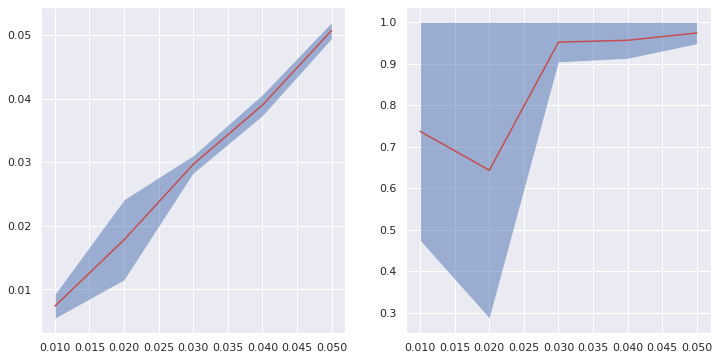

In [0]:
per_s_ss = np.array(per_s_ss)
per_s_T = np.array(per_s_T)

recovered_strength = np.array(recovered_strength)
mean_ss_list = []
sigma_upper_list = []
sigma_lower_list = []

relative_ss_list = []
relative_sigma_upper_list = []
relative_sigma_lower_list = []

for i,signal_strength in enumerate(signal_strengths[:len(recovered_strength)]):
  mean_ss = np.mean(recovered_strength[i])
  std = recovered_strength[i].std()
  mean_ss_list.append(mean_ss)
  sigma_upper_list.append(mean_ss + std)
  sigma_lower_list.append(mean_ss - std)

  relative = (mean_ss - signal_strength) / mean_ss
  relative_ss_list.append(relative)
  relative_sigma_upper_list.append(relative + std / mean_ss)
  relative_sigma_lower_list.append(relative - std / mean_ss)

plt.figure(figsize = (12,6))
plt.grid(True)
plt.subplot(1, 2, 1)
plt.fill_between(signal_strengths[:len(recovered_strength)],sigma_lower_list , sigma_upper_list,alpha = 0.5)
plt.plot(signal_strengths[:len(recovered_strength)], mean_ss_list , c= 'r')
plt.subplot(1, 2, 2)
plt.fill_between(signal_strengths[:len(recovered_strength)],relative_sigma_lower_list , relative_sigma_upper_list, alpha = 0.5)
plt.plot(signal_strengths[:len(recovered_strength)], relative_ss_list, c= 'r')
plt.show()


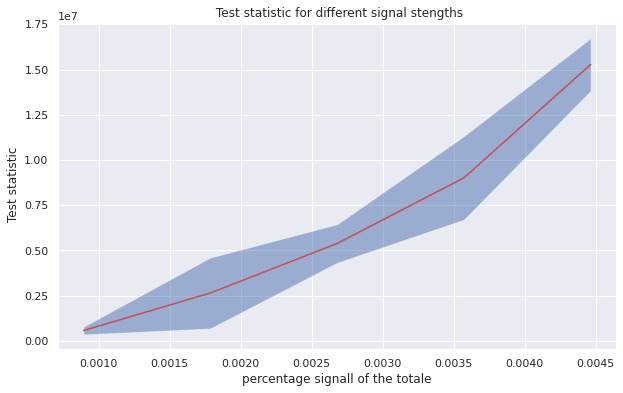

In [0]:
signal_perc = np.sum(signal_c) / np.sum(simulated_backgrounds + signal_c)
mean_T_list = []
sigma_upper_list_T = []
sigma_lower_list_T = []

T_values = np.array(T_values)

for i,signal_strength in enumerate(signal_strengths[:len(T_values)]):
  mean_T = np.mean(T_values[i])
  std = T_values[i].std()
  mean_T_list.append(mean_T)
  sigma_upper_list_T.append(mean_T + std)
  sigma_lower_list_T.append(mean_T - std)

plt.figure(figsize = (10,6))
plt.plot(signal_perc*signal_strengths[:len(T_values)],mean_T_list, 'r')
plt.fill_between(signal_perc *signal_strengths[:len(T_values)],sigma_upper_list_T , sigma_lower_list_T, alpha = 0.5)
plt.xlabel('percentage signall of the totale')
plt.ylabel(' Test statistic')

plt.title(' Test statistic for different signal stengths')

plt.show()

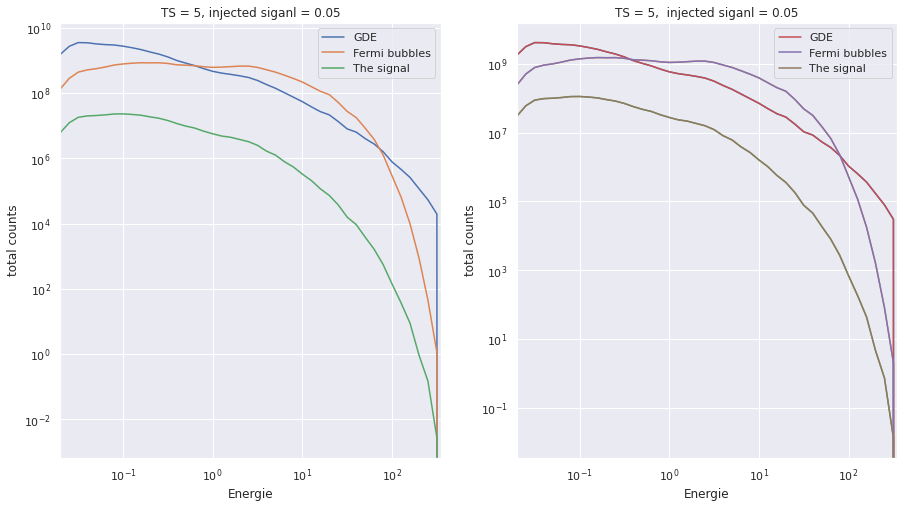

In [0]:
plt.figure(figsize = (15,8))

factors = tot_values1[0]
T = T_values[0]

GDE_per_E = []
Fermi_per_E = []
signal_per_E = []
for i in range(0,47):
  tot_sum = 0
  for j in range(0,8):
    tot_sum += factors[j] *  np.sum(simulated_backgrounds[j,i,:,:])
  GDE_per_E.append(tot_sum)
  Fermi_per_E.append(factors[8] * np.sum(simulated_backgrounds[8,i,:,:]))
  signal_per_E.append(factors[9] *np.sum(signal_c[i]))



plt.subplot(1, 2, 1)
plt.title(f"TS = {TS}, injected siganl = {signal_strength}")
plt.plot(energies,GDE_per_E, label = "GDE")
plt.plot(energies,Fermi_per_E, label = "Fermi bubbles")
plt.plot(energies, signal_per_E, label = "The signal")
plt.xlim(0.02,350)
plt.xscale('log')
plt.yscale('log')

plt.ylabel('total counts')
plt.xlabel('Energie')

plt.legend()

factors = tot_values1[-1]
T = T_values[-1]



GDE_per_E = []
Fermi_per_E = []
signal_per_E = []
for i in range(0,47):
  tot_sum = 0
  for j in range(0,8):
    tot_sum += factors[j] *  np.sum(simulated_backgrounds[j,i,:,:])
  GDE_per_E.append(tot_sum)
  Fermi_per_E.append(factors[8] * np.sum(simulated_backgrounds[8,i,:,:]))
  signal_per_E.append(factors[9] *np.sum(signal_c[i]))


plt.subplot(1, 2, 2)
plt.title(f"TS = {TS},  injected siganl = {signal_strength}")
plt.plot(energies,GDE_per_E)
plt.plot(energies,Fermi_per_E)
plt.plot(energies, signal_per_E)
plt.plot(energies,GDE_per_E, label = "GDE")
plt.plot(energies,Fermi_per_E, label = "Fermi bubbles")
plt.plot(energies, signal_per_E, label = "The signal")
plt.xlim(0.02,350)
plt.xscale('log')
plt.yscale('log')

plt.ylabel('total counts')
plt.xlabel('Energie')
plt.legend()
plt.show()


In [0]:
print (tot_values1)

[<ValueView of Minuit at c852618>
  x0: 0.8890931693310955
  x1: 0.7057180312973332
  x2: 0.09451881225615577
  x3: 0.9690034328495845
  x4: 0.9345247884829461
  x5: 0.974772566028308
  x6: 0.293721906634945
  x7: 1.5656879402733093
  x8: 0.8312808978480007
  x9: 0.010097640041609957, <ValueView of Minuit at c4c9e18>
  x0: 1.145370932280515
  x1: 0.382333063706497
  x2: 9.965638896246485
  x3: 0.00819903420685164
  x4: 1.1442302135099192
  x5: 1.389970315473899
  x6: 0.004365552722652155
  x7: 1.5192546260500746
  x8: 1.466534218543315
  x9: 0.01750781647049804, <ValueView of Minuit at 9007818>
  x0: 1.2096397318182976
  x1: 1.0845704869718515
  x2: 7.544501517455181
  x3: 0.3629528037283103
  x4: 0.7411165165011796
  x5: 0.7783154458923691
  x6: 0.08096452158968981
  x7: 0.05374937898514898
  x8: 1.164926324687825
  x9: 0.028452494435347475, <ValueView of Minuit at ba0f918>
  x0: 1.3458819576509833
  x1: 0.8446184841792836
  x2: 0.16267923526767536
  x3: 0.3709679663752874
  x4: 1.119

f


## Same for the alternative GDE

In [0]:
sigma = 0.3
long = True
times = 8
recovered_strength = []
T_values = []
signal_strengths = np.linspace(0.01,0.05,  5)
tot_values1 = []

for signal_strength in signal_strengths:
  per_s_ss = []
  per_s_T = []
  for i in range(times):
    M2 = analysis(signal_strength, model_backgrounds, signal_c, sigma, simulated_backgrounds, long)
    T, c,d, m_0, m_1 = M2.Test_stat()
    per_s_T.append(T)
    per_s_ss.append(m_1.values[9])
    print (f"ss {signal_strength} at trial {i}: T = {T} and rss = {m_1.values[9]}")

  
  tot_values1.append(m_1.values) 
  
  per_s_T = np.array(per_s_T)
  mean = np.mean(per_s_T)
  std = per_s_T.std()
  perc = std / mean  * 100

  per_s_ss = np.array(per_s_ss)

  mean_ss = per_s_ss.mean()
  std_ss = per_s_ss.std()
  perc_ss = std_ss / mean_ss * 100
  print ("------------")
  print (f"for s = {signal_strength} we get a average Ts of {'{:.2e}'.format(mean)} +/- {round(perc,1)} %")
  print (f"for s = {signal_strength} we extract a signal of {'{:.2e}'.format(mean_ss)} +/- {round(perc_ss,1)} % ")
  print ("------------")
  T_values.append(per_s_T)
  recovered_strength.append(per_s_ss)


ss 0.01 at trial 0: T = 105515.59423828125 and rss = 8.324411160387513e-08
ss 0.01 at trial 1: T = 29034.11767578125 and rss = 4.046847375482887e-05
ss 0.01 at trial 2: T = 10570.141357421875 and rss = 2.2146814365742173e-06
ss 0.01 at trial 3: T = -17867.64404296875 and rss = 2.6997022051222785e-06
ss 0.01 at trial 4: T = 2181.48193359375 and rss = 4.357220407258389e-06
ss 0.01 at trial 5: T = 19266.870361328125 and rss = 7.024062196880898e-06
ss 0.01 at trial 6: T = -9084423.264892578 and rss = 3.978516276426092e-06
ss 0.01 at trial 7: T = 520382.54150390625 and rss = 8.235766790765098e-08
------------
for s = 0.01 we get a average Ts of -1.05e+06 +/- -289.0 %
for s = 0.01 we extract a signal of 7.61e-06 +/- 165.5 % 
------------
ss 0.02 at trial 0: T = -4438.725830078125 and rss = 8.760705762278498e-05
ss 0.02 at trial 1: T = -61712.269287109375 and rss = 9.803159078947132e-07
ss 0.02 at trial 2: T = -7937.4599609375 and rss = 6.343411602049986e-05
ss 0.02 at trial 3: T = -32644.352

In [0]:
per_s_ss = np.array(per_s_ss)
per_s_T = np.array(per_s_T)

recovered_strength = np.array(recovered_strength)
mean_ss_list = []
sigma_upper_list = []
sigma_lower_list = []

relative_ss_list = []
relative_sigma_upper_list = []
relative_sigma_lower_list = []

for i,signal_strength in enumerate(signal_strengths[:len(recovered_strength)]):
  mean_ss = np.mean(recovered_strength[i])
  std = recovered_strength[i].std()
  mean_ss_list.append(mean_ss)
  sigma_upper_list.append(mean_ss + std)
  sigma_lower_list.append(mean_ss - std)

  relative = (mean_ss - std) / mean_ss
  relative_ss_list.append(relative)
  relative_sigma_upper_list.append(relative + std / mean_ss)
  relative_sigma_lower_list.append(relative - std / mean_ss)

plt.figure(figsize = (12,6))
plt.grid(True)
plt.subplot(1, 2, 1)
plt.fill_between(signal_strengths[:len(recovered_strength)],sigma_lower_list , sigma_upper_list,alpha = 0.5)
plt.plot(signal_strengths[:len(recovered_strength)], mean_ss_list , c= 'r')
plt.subplot(1, 2, 2)
plt.fill_between(signal_strengths[:len(recovered_strength)],relative_sigma_lower_list , relative_sigma_upper_list, alpha = 0.5)
plt.plot(signal_strengths[:len(recovered_strength)], relative_ss_list, c= 'r')
plt.show()

In [0]:
signal_perc = np.sum(signal_c) / np.sum(simulated_backgrounds + signal_c)
mean_T_list = []
sigma_upper_list_T = []
sigma_lower_list_T = []

T_values = np.array(T_values)

for i,signal_strength in enumerate(signal_strengths[:len(T_values)]):
  mean_T = np.mean(T_values[i])
  std = T_values[i].std()
  mean_T_list.append(mean_T)
  sigma_upper_list_T.append(mean_T + std)
  sigma_lower_list_T.append(mean_T - std)

plt.figure(figsize = (10,6))
plt.plot(signal_perc*signal_strengths[:len(T_values)],mean_T_list, 'r')
plt.fill_between(signal_perc *signal_strengths[:len(T_values)],sigma_upper_list_T , sigma_lower_list_T, alpha = 0.5)
plt.xlabel('percentage signall of the totale')
plt.ylabel(' Test statistic')

plt.title(' Test statistic for different signal stengths')

plt.show()

In [0]:
print (tot_values1)

In [0]:
plt.figure(figsize = (15,8))

factors = tot_values1[0]
T = T_values[0]

GDE_per_E = []
Fermi_per_E = []
signal_per_E = []
for i in range(0,47):
  tot_sum = 0
  for j in range(0,8):
    tot_sum += factors[j] *  np.sum(simulated_backgrounds[j,i,:,:])
  GDE_per_E.append(tot_sum)
  Fermi_per_E.append(factors[8] * np.sum(simulated_backgrounds[8,i,:,:]))
  signal_per_E.append(factors[9] *np.sum(signal_c[i]))



plt.subplot(1, 2, 1)
plt.title(f"TS = {T}, injected siganl = {signal_strengths[0]}")
plt.plot(energies,GDE_per_E, label = "GDE")
plt.plot(energies,Fermi_per_E, label = "Fermi bubbles")
plt.plot(energies, signal_per_E, label = "The signal")
plt.xlim(0.02,350)
plt.xscale('log')
plt.yscale('log')

plt.ylabel('total counts')
plt.xlabel('Energie')

plt.legend()

factors = tot_values1[-1]
T = T_values[-1]



GDE_per_E = []
Fermi_per_E = []
signal_per_E = []
for i in range(0,47):
  tot_sum = 0
  for j in range(0,8):
    tot_sum += factors[j] *  np.sum(simulated_backgrounds[j,i,:,:])
  GDE_per_E.append(tot_sum)
  Fermi_per_E.append(factors[8] * np.sum(simulated_backgrounds[8,i,:,:]))
  signal_per_E.append(factors[9] *np.sum(signal_c[i]))


plt.subplot(1, 2, 2)
plt.title(f"TS = {T},  injected siganl = {signal_strengths[-1]}")
plt.plot(energies,GDE_per_E)
plt.plot(energies,Fermi_per_E)
plt.plot(energies, signal_per_E)
plt.plot(energies,GDE_per_E, label = "GDE")
plt.plot(energies,Fermi_per_E, label = "Fermi bubbles")
plt.plot(energies, signal_per_E, label = "The signal")
plt.xlim(0.02,350)
plt.xscale('log')
plt.yscale('log')

plt.ylabel('total counts')
plt.xlabel('Energie')
plt.legend()
plt.show()